In [1]:
import sys
import copy
import time
import cupy as cp
import numpy as np
import scipy.linalg as la
from os.path import abspath, join
import matplotlib.pyplot as plt
from control.phaseplot import phase_plot

from os.path import abspath, join, expanduser
sys.path.append(abspath(join('..')))
from BRATVisualization.DIVisu import DoubleIntegratorVisualizer
sys.path.append(abspath(join('../..')))

# This one for Lyapunov Learner
sys.path.append(abspath(join('../../../')))
from LevelSetPy.Utilities import *
from LevelSetPy.Grids import createGrid
from LevelSetPy.Helper import postTimeStepTTR
from LevelSetPy.Visualization import implicit_mesh
from LevelSetPy.DynamicalSystems import DoubleIntegrator

# POD Decomposition
from LevelSetPy.POD import *
from LevelSetPy.DynamicalSystems import DoubleIntegratorROB

# Chambolle-Pock for Total Variation De-Noising
from LevelSetPy.Optimization import chambollepock

# Value co-state and Lax-Friedrichs upwinding schemes
from LevelSetPy.InitialConditions import *
from LevelSetPy.SpatialDerivative import upwindFirstENO2
from LevelSetPy.ExplicitIntegration import artificialDissipationGLF, odeCFL2, \
            odeCFLset,termRestrictUpdate, termLaxFriedrichs

### Create state space and value function.

+ This would be the grid upon which we are going to control 
the car/unicycle etc -- basically anything that may have 
double integrator dynamics.

+ In addition, we'll generate the analytical solution to the time to reach the origin problem on the grid. Let's call this variable `attr`. 

+ Our initial value function will be constructed as an implicit function on the grid with a signed distance function in the geometry of a sphere with radius, $r$.

In [2]:
dint = DoubleIntegrator
u_bound = 1

In [3]:

def preprocessing():
    global dint, u_bound

    gmin = np.array(([[-1, -1]]),dtype=np.float64).T
    gmax = np.array(([[1, 1]]),dtype=np.float64).T
    g = createGrid(gmin, gmax, 101, None)

    eps_targ = 1.0
    target_rad = .2

    dint = DoubleIntegrator(g, u_bound)
    attr = dint.mttr() - target_rad
    if strcmp(args.init_cond, 'attr'):
        value_func_init = attr
    elif strcmp(args.init_cond, 'circle'):
        value_func_init = shapeSphere(g, zeros(g.dim, 1), target_rad)
    elif strcmp(args.init_cond, 'square'):
        value_func_init = shapeRectangleByCenter(g, zeros(g.dim, 1), \
                                    2*target_rad*ones(g.dim,1))

    attr = np.maximum(0, attr)

    return g, attr, value_func_init


In [4]:
def show_init_levels(g, attr, value_func_init):

    f, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))

    ax1.contour(g.xs[0], g.xs[1], attr, colors='red')
    ax1.set_title('Analytical TTR')
    ax1.set_xlabel(r"$x_1 (m)$")
    ax1.set_ylabel(r"$x_2 (ms^{-1})$")
    ax1.set_xlim([-1.02, 1.02])
    ax1.set_ylim([-1.01, 1.01])
    ax1.grid()

    ax2.contour(g.xs[0], g.xs[1], value_func_init, colors='blue')
    ax2.set_title('Numerical TTR')
    ax2.set_xlabel(r"$x_1 (m)$")
    ax2.set_xlim([-1.02, 1.02])
    ax2.set_ylim([-1.01, 1.01])
    ax2.grid()

    f.suptitle(f"Levelsets")

    f.canvas.draw()
    f.canvas.flush_events()
    time.sleep(args.pause_time)

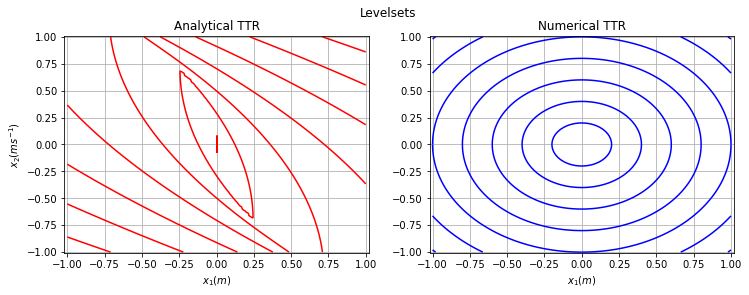

In [5]:
args = Bundle(dict(init_cond='circle', visualize=True, pause_time=1))
g, attr, value_func_init = preprocessing()
show_init_levels(g, attr, value_func_init)

#### Trajectories in the $x_1$-$x_2$ plane

\begin{align}
x_1 &= \xi_1 + \frac{1}{2} \Delta x_2^2 - \frac{1}{2} \Delta \xi_2^2, \text{ where } \quad t = \Delta(x_2 - \xi_2)  \\
x_2 &= \xi_2 + \Delta t
\end{align}

where $\Delta= u \equiv \pm 1$, 

$t$ is the time it takes to arrive at our goal; 

and $x_1$ and $x_2$ are the position and velocity of the body respectively.

In [6]:

fontdict = {'fontsize':28, 'fontweight':'bold'}
def show_trajectories(g, attr, x_i):
	### pick a bunch of initial conditions
	Δ = lambda u: u  # u is either +1 or -1
	
	# how much timesteps to consider
	t = np.linspace(-1, 1, 100)
	# do implicit euler integration to obtain x1 and x2
	x1p = np.empty((len(x_i), g.xs[0].shape[1], len(t)))
	x2p = np.empty((len(x_i), g.xs[1].shape[1], len(t)))
	# states under negative control law
	x1m  = np.empty((len(x_i), g.xs[0].shape[1], len(t)))
	x2m = np.empty((len(x_i), g.xs[1].shape[1], len(t)))

	fig, ax1 = plt.subplots(1, 1, figsize=(16,9))

	for i in range(len(x_i)):
		for k in range(len(t)):
			x2p[i, :,k] = x_i[i][1] + Δ(u_bound) * t[k]
			x1p[i, :,k] = x_i[i][0] + .5 * Δ(u_bound) * x2p[i,:,k]**2 - .5 * Δ(u_bound) * x_i[i][1]**2
			# state trajos under -ve control law
			x2m[i, :,k] = x_i[i][1] + Δ(-u_bound) * t[k]
			x1m[i, :,k] = x_i[i][0]+.3 + .5 * Δ(-u_bound) * x2p[i,:,k]**2 - .5 * Δ(-u_bound) * x_i[i][1]**2


	# Plot a few snapshots for different initial conditions.
	color = iter(plt.cm.inferno_r(np.linspace(.25, 1, 2*len(x_i))))
	# repeat for legends
	for init_cond in range(0, len(x_i)):
		# state trajectories are unique for every initial cond
		# here, we pick the last state
		ax1.plot(x1p[init_cond, -1, :], x2p[init_cond, -1, :], linewidth=3, color=next(color), \
			label=rf"x$_{init_cond+1}^+={x_i[init_cond]}$")
		ax1.plot(x1m[init_cond, -1, :], x2m[init_cond, -1, :], '-.', linewidth=3, color=next(color) , \
			label=rf"x$_{init_cond+1}^-={x_i[init_cond]}$")

		#plot the quivers
		ax1.grid('on')
		up, vp = x2p[init_cond, -1, ::len(t)//2], [Δ(u_bound)]*len(x2p[init_cond, -1, ::len(t)//2])
		um, vm = x2m[init_cond, -1, ::len(t)//2], [Δ(-u_bound)]*len(x2m[init_cond, -1, ::len(t)//2])
		ax1.quiver(x1p[init_cond, -1, ::len(t)//2], x2p[init_cond, -1, ::len(t)//2], up, vp, angles='xy')
		ax1.quiver(x1m[init_cond, -1, ::len(t)//2], x2m[init_cond, -1, ::len(t)//2], um, vm, angles='xy')

	ax1.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
	ax1.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
	ax1.tick_params(axis='both', which='major', labelsize=28)
	ax1.tick_params(axis='both', which='minor', labelsize=18)
	ax1.set_title(rf"State Trajectories.", fontdict=fontdict)
	ax1.legend(loc="center left", fontsize=8) 
	
	fig.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/doub_int_trajos.jpg"), 
                bbox_inches='tight',facecolor='None')
	# fig.canvas.draw()
	# fig.canvas.flush_events()
	time.sleep(args.pause_time)


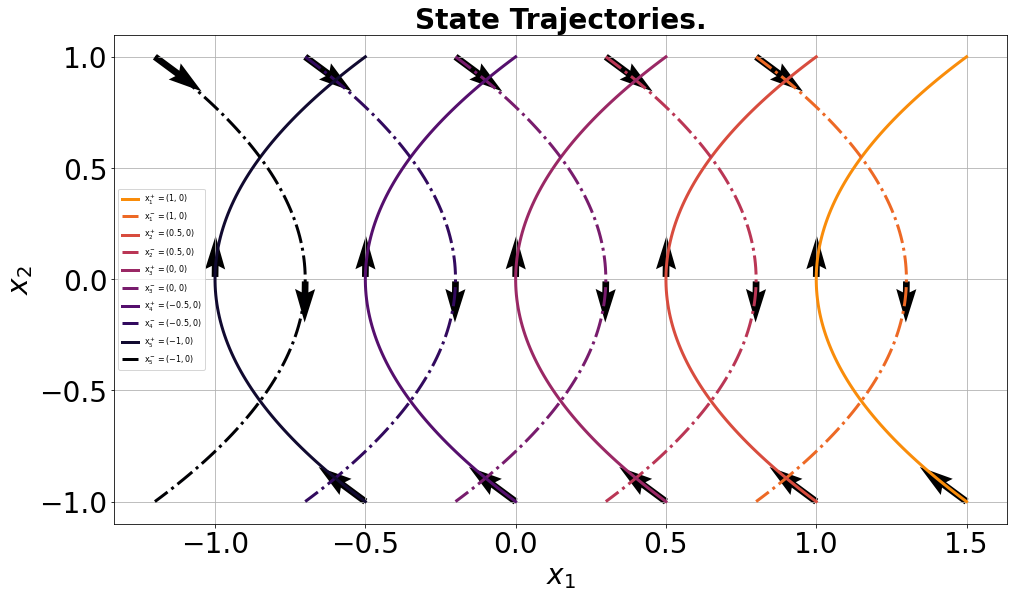

In [7]:

    xis = [(1,0), (.5, 0),  (0,0), (-.5, 0), (-1,0)]
    show_trajectories(g, attr, xis)

In [8]:
### Plot the switching curve
fontdict = {'fontsize':42, 'fontweight':'bold'}
def show_switch_curve():
	# Plot all vectograms(snapshots) in space and time.
	fig3, ax3 = plt.subplots(1, 1, figsize=(14,13))
	ax3.grid('on')
	color = iter(plt.cm.seismic_r(np.linspace(.25, 1, 4)))
	ax3.plot(dint.Gamma[0,:], linewidth=7.5, color=next(color), label=rf"Switching Curve, $\gamma$")
	xmin, xmax = ax3.get_xlim()
	ymin, ymax = ax3.get_ylim()
	ax3.hlines(0, xmin, xmax, colors='black', linestyles='solid', label='')
	ax3.vlines(len(dint.Gamma)//2, ymin, ymax, colors='black', linestyles='solid', label='')

	ax3.set_xlim(0, 100)
	ax3.set_ylim(-.55, .55)

	ax3.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
	ax3.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
	ax3.set_title(rf"Switching Curve, $\gamma$", fontdict=fontdict)
	ax3.tick_params(axis='both', which='major', labelsize=42)
	ax3.tick_params(axis='both', which='minor', labelsize=22)
	ax3.legend(fontsize=28)			
	plt.tight_layout()

	# fig.suptitle("The Double Integral Plant.", fontdict=fontdict)
	fig3.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/switching_curve.jpg"),
				bbox_inches='tight',facecolor='None')

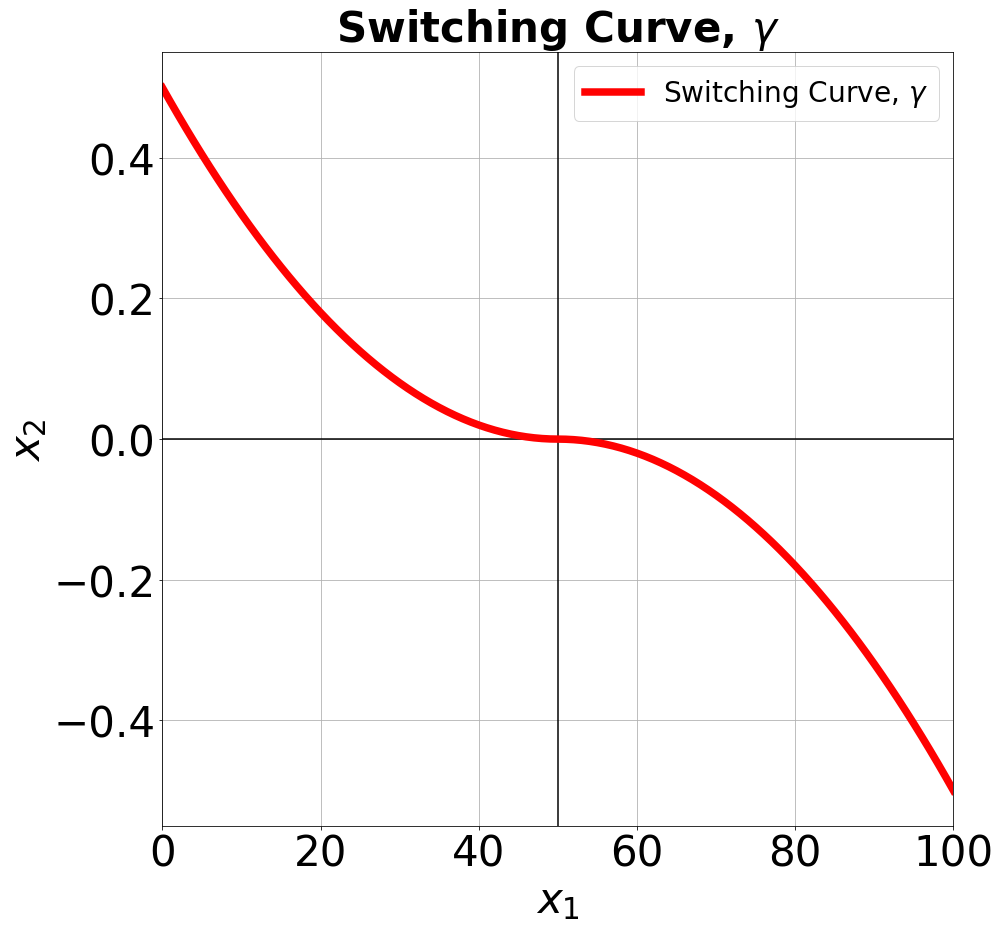

In [9]:
show_switch_curve()

### Plot the Analytical Time to Reach the origin


In [10]:
def show_attr():
    # Plot all vectograms(snapshots) in space and time.
    fig2, ax2 = plt.subplots(1, 1, figsize=(16,9))
    cdata = ax2.pcolormesh(g.xs[0], g.xs[1], attr, shading="nearest", cmap="magma_r")
    plt.colorbar(cdata, ax=ax2, extend="both")
    ax2.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
    ax2.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
    ax2.set_title(r"Reach Time", fontdict=fontdict)
    ax2.tick_params(axis='both', which='major', labelsize=28)
    ax2.tick_params(axis='both', which='minor', labelsize=18)

    # fig.suptitle("The Double Integral Plant.", fontdict=fontdict)
    fig2.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/attr.jpg"),
                bbox_inches='tight',facecolor='None')


### Examining the Level Sets

The analytical time-to-reach is resolved as

\begin{align}
  &\left[\left(x_2 + \sqrt{4 x_1 + 2 x_2^2}\right) \, \cdot \, \left(x_1 > \Gamma\right)\right] + 
            &\left[\left(-x_2 + \sqrt{2x_2^2 - 4 x_1}\right)  \, \cdot \,  (x_1 < \Gamma) \right] +
            |x_2|  \, \cdot \,  \left(x_1 = \Gamma\right).
\end{align}

where $\Gamma$ is the switching curve defined as 

\begin{align}
    \Gamma = -\dfrac{1}{2} \cdot x_2 \dot |x_2|
\end{align}

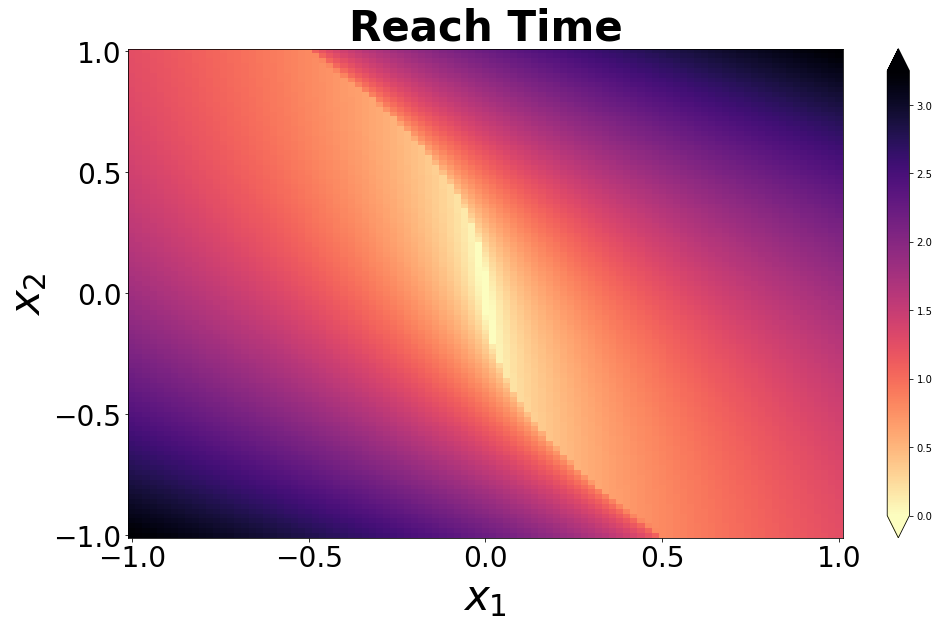

In [11]:
show_attr()

Let us consider the set of states that can be forced to the origin in the same minimum time $t^\star$. 

This is otherwise termed the _isochrones_ of the set $S(t^\star)$ at $t^\star$.

This is given by 

\begin{align}
   x_1 &= -\dfrac{1}{2} x_2^2 + \dfrac{1}{4}(t^\star - x_2)^2   \quad &for \quad x_1 > -\dfrac{1}{2} x_2 |x_2| \\
   x_1 &= -\dfrac{1}{2} x_2 - \dfrac{1}{4}(t^\star + x_2)^2   \quad &for \quad x_1 < -\dfrac{1}{2} x_2 |x_2| \\
   x_1 &= x_1 - \dfrac{1}{2} x_2 t^\star   \quad &for \quad x_1 = -\dfrac{1}{2} x_2 |x_2| 
\end{align}

In [12]:
def isochoner(tstar = 0.5):
    above_curve = -.5 * dint.grid.xs[1]**2 + .25*  (tstar - dint.grid.xs[1])**2 
    below_curve = .5 * dint.grid.xs[1]**2 - .25 * (tstar +  dint.grid.xs[1])**2 
    on_curve =  -.5 * (dint.grid.xs[1] * tstar)

    return above_curve, below_curve, on_curve

tt = dint.mttr()
above_curve, below_curve, on_curve = isochoner(tt)
isochrones = above_curve+below_curve+on_curve

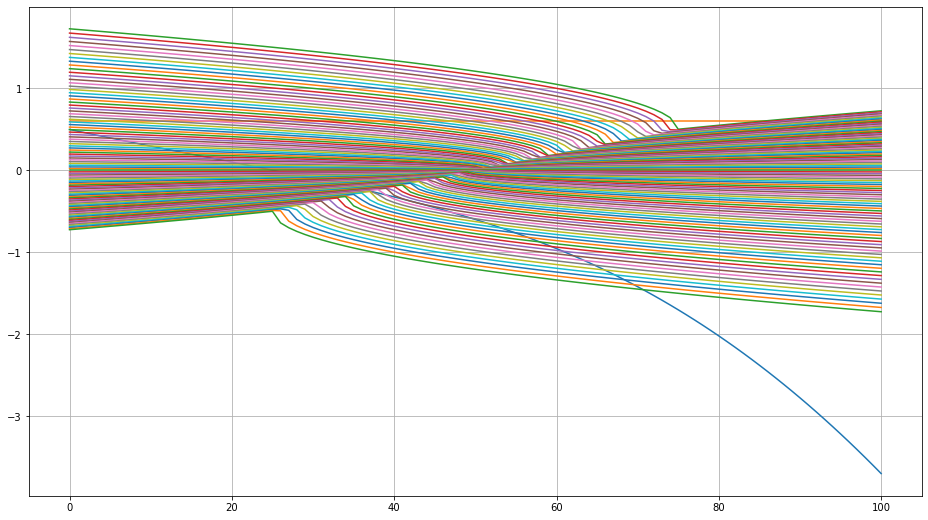

In [13]:
f, ax = plt.subplots(1, 1, figsize=(16,9))
ax.grid('on')

idx = 80
# ax.plot(above_curve[idx], label='above_curve')
# ax.plot(below_curve[idx], label='below_curve')
# ax.plot(on_curve[idx], label='on_curve')
# ax.plot(above_curve[idx]+below_curve[idx]+on_curve[idx], label='on_curve')
ax.plot(below_curve[idx], label='on_curve')
ax.plot(above_curve[idx], label='above_curve')
ax.plot(on_curve, label='above_curve')
plt.show()

### Optimize the trajectories

In [14]:
global dint, u_bound
#turn the state space over to the gpu
g.xs = [cp.asarray(x) for x in g.xs]
finite_diff_data = Bundle(dict(
            innerFunc = termLaxFriedrichs,
            innerData = Bundle({'grid':g,
                'hamFunc': dint.hamiltonian,
                'partialFunc': dint.dissipation,
                'dissFunc': artificialDissipationGLF,
                'derivFunc': upwindFirstENO2,
                }),
                positive = False,  # direction to grow the updated level set
            ))

small = 100*eps
t_span = np.linspace(0, 2.0, 20)
options = Bundle(dict(factorCFL=0.75, stats='on', maxStep=realmax, 						singleStep='off', postTimestep=postTimeStepTTR))

y = copy.copy(value_func_init.flatten())
y, finite_diff_data = postTimeStepTTR(0, y, finite_diff_data)
value_func = cp.asarray(copy.copy(y.reshape(g.shape)))

(101, 101) (101,) (101, 101)
min_rank  8


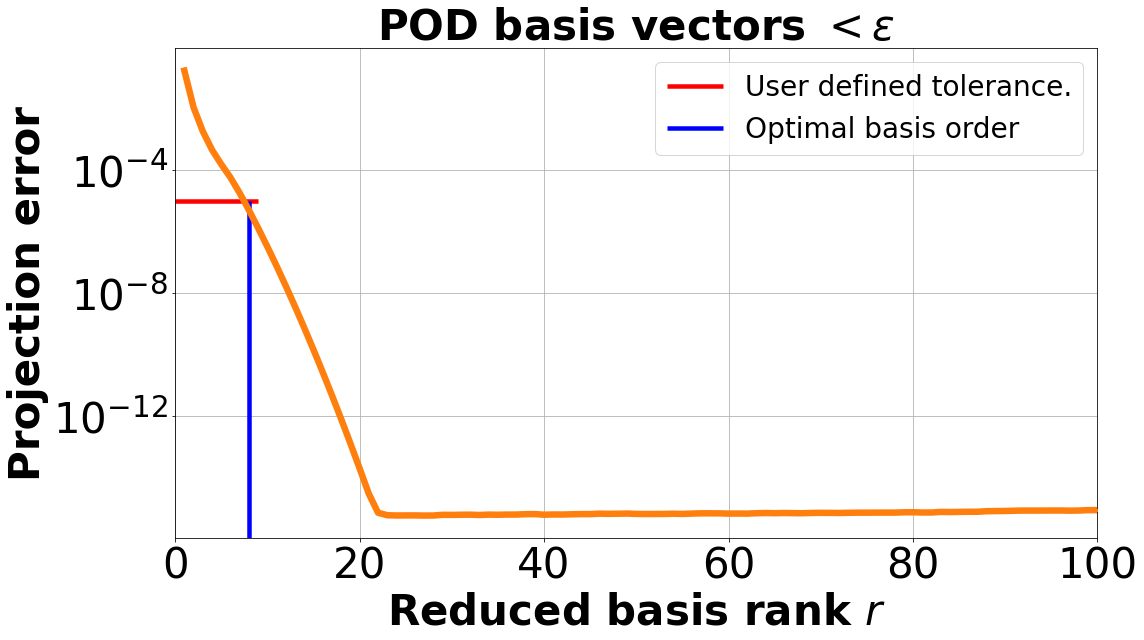

In [15]:
value_init = value_func_init

U, Sigma, V = la.svd(value_init, full_matrices=False)

# sanity checks
print(U.shape, Sigma.shape, V.shape)
np.allclose(U@np.diag(Sigma)@V, value_init)

# informed reduced basis rank
min_rank = minimal_projection_error(value_init, U, eps=1e-5, plot=True)
print('min_rank ', min_rank)

Ur, Sigmar, Vr = U[:,:min_rank], Sigma[:min_rank], V[:,:min_rank]
# be sure the singular values are arranged in descending order

# plt.plot(Sigmar)
f = plt.gcf()
ax = plt.gca()
ax.grid('on')
ax.set_title('POD basis vectors $<\epsilon$', fontdict=fontdict)
ax.set_xlabel(r"Reduced basis rank $r$", fontdict=fontdict)
ax.set_ylabel(r"Projection error", fontdict=fontdict)
ax.tick_params(axis='both', which='major', labelsize=42)
ax.tick_params(axis='both', which='minor', labelsize=22)
ax.legend(fontsize=28)			
plt.tight_layout()
f.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/proj_error.jpg"),
            bbox_inches='tight',facecolor='None')


In [16]:

# project value function in reduced basis
value_rob = (Ur.T @ value_init).T
print(f'Value function in ROB: {value_rob.shape}')

Value function in ROB: (101, 8)


In [17]:
#construct the ttr on the reduced grid and fit a MLE with value_rob

value_rob = Ur.T @ value_init @ Ur

In [18]:

# calculate associated rhs functions on the reduced model
gmin = np.array(([[-1, -1]]),dtype=np.float64).T
gmax = np.array(([[1, 1]]),dtype=np.float64).T
gr = createGrid(gmin, gmax, np.array(([value_rob.shape])), None)

dint_rob = DoubleIntegratorROB(gr)
reduced_data = Bundle(dict(innerFunc = termLaxFriedrichs,
            innerData = Bundle({'grid':gr,
                'hamFunc': dint_rob.hamiltonian,
                'partialFunc': dint_rob.dissipation,
                'dissFunc': artificialDissipationGLF,
                'CoStateCalc': upwindFirstENO2,
                }),
                positive = False,  # we want to solve a min problem
            ))

y = copy.copy(value_rob.flatten())
y, reduced_data = postTimeStepTTR(0, y, reduced_data)
value_func = cp.asarray(copy.copy(y.reshape(gr.shape)))

In [19]:
gr.shape

(8, 8)

In [20]:
### Reconstruct the problem on the lower grid using the attr on the V

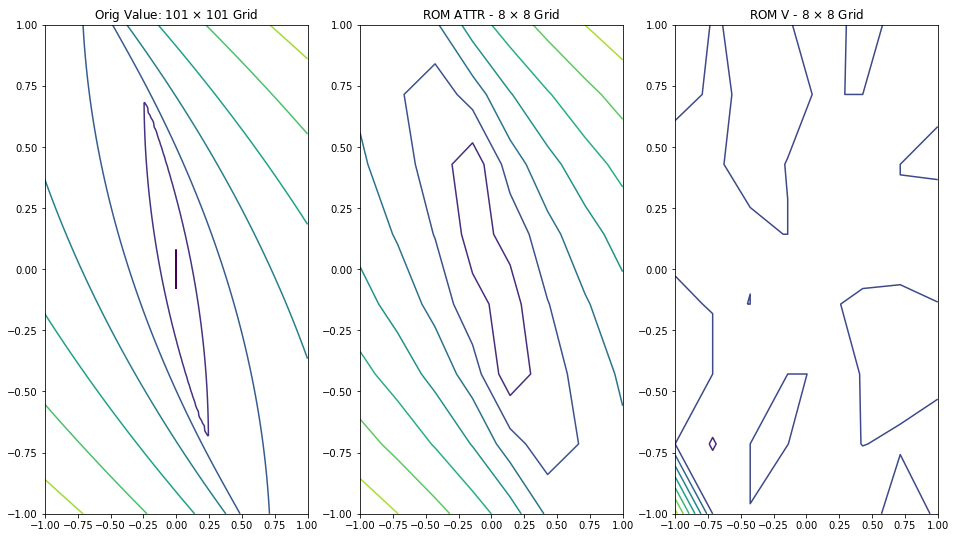

In [21]:
f, ax = plt.subplots(1,3, figsize=(16, 9))
mttr_red = dint_rob.mttr()
ax = plt.subplot(131)
ax.set_title(rf'Orig Value: {value_init.shape[0]} $\times$ {value_init.shape[1]} Grid')
ax.contour(g.xs[0].get(), g.xs[1].get(), attr)

ax = plt.subplot(132)
ax.contour(gr.xs[0], gr.xs[1], mttr_red)
ax.set_title(rf'ROM ATTR - {value_rob.shape[0]} $\times$ {value_rob.shape[1]} Grid')


ax = plt.subplot(133)
ax.contour(gr.xs[0], gr.xs[1], value_rob)
ax.set_title(rf'ROM V - {value_rob.shape[0]} $\times$ {value_rob.shape[1]} Grid')

plt.show()

In [22]:
# better yet, solve an MLE between the Vr that was projected and the original value on the 

In [39]:
import scipy.linalg as spla
from numpy.linalg import LinAlgError

In [42]:
K, N, Do = 6, value_init.shape[0], value_init.shape[1]
sigma_global = np.zeros((K, Do, Do))
logmass = np.log(1.0 / K) * np.ones((K, 1))
mass = (1.0 / K) * np.ones((K, 1))
mu_global = zeros((K, Do))
probs = cell(K)

# sample indices
sample_idx = np.random.randint(0, K, size=(1, N))
for i in range(K):
    cluster_idx = (sample_idx==i)[0]
    
    # get sufficient statistics: mean and sum of sq devs
    #print(i, ' cluster_idx ', cluster_idx[cluster_idx].shape, ' diff ', diff.shape)
    mu = np.mean(value_init[cluster_idx,:], axis=0)

    # sum of squared deviations, 
    diff = (value_init[cluster_idx,: ] - mu).T
    sigma = (1.0/K)*(diff@diff.T)

    if not isinstance(sigma, np.ndarray):
        temp = np.abs(sigma) + realmin
    else:
        temp = np.abs(np.linalg.det(sigma)) + realmin
    
    D = value_init[cluster_idx,:].shape[-1]
    butt = np.sqrt( ((2*np.pi)**D)*temp)
    

    try:
        L = spla.cholesky(sigma, lower=True)
    except LinAlgError as e:
        print('LinAlgError: %s', e)
        
    soln = spla.solve_triangular(L, sigma, lower=True)
    probs[i] = diff.T@soln@diff

    print(f'probs[i] {probs[i].shape}')

LinAlgError: %s 6-th leading minor of the array is not positive definite


NameError: name 'L' is not defined

In [44]:
from LyapunovLearner.scripts.gmm.gmm import GMM

In [47]:
import logging
import numpy as np
import scipy.linalg
import scipy.linalg as LA
from scipy.cluster.vq import vq, kmeans2, whiten
from numpy.linalg import LinAlgError

logger = logging.getLogger(__name__)


def logsum(vec, axis=0, keepdims=True):
    #TODO: Add a docstring.
    maxv = np.max(vec, axis=axis, keepdims=keepdims)
    maxv[maxv == -float('inf')] = 0
    return np.log(np.sum(np.exp(vec-maxv), axis=axis, keepdims=keepdims)) + maxv

def check_sigma(A):
    """
        checks if the sigma matrix is symmetric
        positive definite before inverting via
        cholesky decomposition

        Lekan Molux. Circa, Summer 2018.
    """
    eigval = np.linalg.eigh(A)[0]
    if np.array_equal(A, A.T) and np.all(eigval>0):
        # logger.debug("sigma is pos. def. Computing cholesky factorization")
        return A
    else:
        # find lowest eigen value
        eta = 1e-6  # regularizer for matrix multiplier
        low = np.amin(np.sort(eigval))
        Anew = low * A + eta * np.eye(A.shape[0])
        return Anew

class GMM(object):
    """
        Gaussian Mixture Model.

        Includes regularization term for when cholesky
        factorization decreases.
    """
    def __init__(self, num_clusters=6, init_sequential=False,\
                    eigreg=False, warmstart=True, use_kmeans=False):
        self.init_sequential = init_sequential
        self.eigreg = eigreg
        self.warmstart = warmstart
        self.sigma = None
        self.use_kmeans = use_kmeans

        # Lekan June 26, 2018
        self.K    = num_clusters
        self.fail = None

        # regularization parameters
        self.eta = 1e-6
        self.delta = 1e-4
        self.eta_min = 1e-6
        self.delta_nut = 2

    def inference(self, pts):
        """
            Evaluate dynamics prior.
            Args:
                pts: A N x D array of points.
        """
        # Compute posterior cluster weights.
        logwts = self.clusterwts(pts)

        # Compute posterior mean and covariance.
        mu0, Phi = self.moments(logwts)

        # Set hyperparameters.
        m = self.N
        n0 = m - 2 - mu0.shape[0]

        # Normalize.
        m = float(m) / self.N
        n0 = float(n0) / self.N
        return mu0, Phi, m, n0

    def clusterwts(self, data):
        """
        Compute cluster weights for specified points under GMM.
        Args:
            data: An N x D array of points
        Returns:
            A K x 1 array of average cluster log probabilities.
        """
        # Compute probability of each point under each cluster.
        logobs = self.estep(data)

        # Renormalize to get cluster weights.
        logwts = logobs - logsum(logobs, axis=1)

        # Average the cluster probabilities.
        logwts = logsum(logwts, axis=0) - np.log(data.shape[0])
        return logwts.T

    def reg_sched(self, increase=False):
        # increase mu
        if increase:
            self.delta = max(self.delta_nut, self.delta * self.delta_nut)
            eta = self.eta * 1.1
        else: # decrease eta
            eta = self.eta
            eta *= 0.09
        self.eta = eta

    def estep(self, data):
        """
        Compute log observation probabilities under GMM.
        Args:
            data: A N x D array of points.
        Returns:
            logobs: A N x K array of log probabilities (for each point
                on each cluster).
        """
        # Constants.
        N, D = data.shape
        K = self.sigma.shape[0]

        logobs = -0.5*np.ones((N, K))*D*np.log(2*np.pi)

        self.fail = True
        while(self.fail):

            self.fail = False

            for i in range(K):
                # print('sigma i ', self.sigma[i].shape, np.eye(self.sigma[i].shape[-1]).shape)
                # print('eta: ', self.eta)
                self.sigma[i] += self.eta * np.eye(self.sigma[i].shape[-1])
                mu, sigma = self.mu[i], self.sigma[i]
                # logger.debug('sigma: {}\n'.format(sigma))
                try:
                    L = scipy.linalg.cholesky(sigma, lower=True)
                except LinAlgError as e:
                    logger.debug('LinAlgError: %s', e)
                    self.fail = True
                    # restart the for loop if sigma aint positive definite
                    logger.debug("sigma non-positive definiteness encountered; restarting")
                    break
                logobs[:, i] -= np.sum(np.log(np.diag(L)))
                diff = (data - mu).T
                soln = scipy.linalg.solve_triangular(L, diff, lower=True)
                logobs[:, i] -= 0.5*np.sum(soln**2, axis=0)

            if self.fail:
                old_eta = self.eta
                self.reg_sched(increase=True)
                logger.debug("Hessian became non positive definite")
                logger.debug('Increasing mu: {} -> {}'.format(old_eta, self.eta))
            else:
                # if successful, decrese mu
                old_eta = self.eta
                self.reg_sched(increase=False)
                logger.debug('Decreasing mu: {} -> {}'.format(old_eta, self.eta))

        logobs += self.logmass.T
        return logobs

    def moments(self, logwts):
        """
            Compute the moments of the cluster mixture with logwts.
            Args:
                logwts: A K x 1 array of log cluster probabilities.
            Returns:
                mu: A (D,) mean vector.
                sigma: A D x D covariance matrix.
        """
        # Exponentiate.
        wts = np.exp(logwts)

        # Compute overall mean.
        mu = np.sum(self.mu * wts, axis=0)

        # Compute overall covariance.
        diff = self.mu - np.expand_dims(mu, axis=0)
        diff_expand = np.expand_dims(self.mu, axis=1) * \
                np.expand_dims(diff, axis=2)
        wts_expand = np.expand_dims(wts, axis=2)
        sigma = np.sum((self.sigma + diff_expand) * wts_expand, axis=0)
        return mu, sigma

    def update(self, data, K=None, max_iterations=100):
        """
        Run EM to update clusters.
        Args:
            data: An N x D data matrix, where N = number of data points.
            K: Number of clusters to use.
        """
        # Constants.
        N  = data.shape[0]
        Do = data.shape[1]

        if K is None:
            K = self.K

        logger.debug('Fitting GMM with %d clusters on %d points.', K, N)

        if (not self.warmstart or self.sigma is None or K != self.sigma.shape[0]):
            # Initialization.
            logger.debug('Initializing GMM.')
            self.sigma = np.zeros((K, Do, Do))
            self.mu = np.zeros((K, Do))
            self.logmass = np.log(1.0 / K) * np.ones((K, 1))
            self.mass = (1.0 / K) * np.ones((K, 1))
            self.N = data.shape[0]
            N = self.N

            # Set initial cluster indices.
            use_kmeans = self.use_kmeans
            # if not self.init_sequential and not use_kmeans:
            cidx = np.random.randint(0, K, size=(1, N))
            for i in range(K):
                cluster_idx = (cidx == i)[0]
                mu = np.mean(data[cluster_idx, :], axis=0)
                diff = (data[cluster_idx, :] - mu).T
                sigma = (1.0 / K) * (diff.dot(diff.T))
                self.mu[i, :] = mu
                self.sigma[i, :, :] = sigma + np.eye(Do) * 2e-6
            # else:
            #     # Initialize clusters with kmeans
            #     iter = 100000
            #     for j in range(iter):
            #         self.mu, cidx = kmeans2(data, K)
            #         for i in range(K):
            #             cluster_idx = (np.reshape(cidx, [1, len(cidx)]) == i)[0]
            #             sigma = np.cov(data[cluster_idx, :].T, data[cluster_idx, :].T)[:Do, :Do]
            #             self.sigma[i, :, :] = sigma + np.eye(Do) * 2e-6

            #         if not np.isnan(self.sigma).any():
            #             break

            #         if j == (iter - 1):
            #             print('Initialization of gaussians in GMM failed.')
            #             exit()

        prevll = -float('inf')
        for itr in range(max_iterations):
            # E-step: compute cluster probabilities.
            logobs = self.estep(data)

            # Compute log-likelihood.
            ll = np.sum(logsum(logobs, axis=1))
            logger.debug('GMM itr %d/%d. Log likelihood: %f',
                         itr, max_iterations, ll)
            if ll < prevll:
                # TODO: Why does log-likelihood decrease sometimes?
                logger.debug('Log-likelihood decreased! Ending on itr=%d/%d',
                             itr, max_iterations)
                break
            if np.abs(ll-prevll) < 1e-5*prevll:
                logger.debug('GMM converged on itr=%d/%d',
                             itr, max_iterations)
                break
            prevll = ll

            # Renormalize to get cluster weights.
            logw = logobs - logsum(logobs, axis=1)
            assert logw.shape == (N, K)

            # Renormalize again to get weights for refitting clusters.
            logwn = logw - logsum(logw, axis=0)
            assert logwn.shape == (N, K)
            w = np.exp(logwn)

            # M-step: update clusters.
            # Fit cluster mass.
            self.logmass = logsum(logw, axis=0).T
            self.logmass = self.logmass - logsum(self.logmass, axis=0)
            assert self.logmass.shape == (K, 1)
            self.mass = np.exp(self.logmass)

            # Reboot small clusters.
            w[:, (self.mass < (1.0 / K) * 1e-4)[:, 0]] = 1.0 / N
            # Fit cluster means.
            w_expand = np.expand_dims(w, axis=2)
            data_expand = np.expand_dims(data, axis=1)
            self.mu = np.sum(w_expand * data_expand, axis=0)
            # Fit covariances.
            wdata = data_expand * np.sqrt(w_expand)
            assert wdata.shape == (N, K, Do)
            for i in range(K):
                # Compute weighted outer product.
                XX = wdata[:, i, :].T.dot(wdata[:, i, :])
                mu = self.mu[i, :]
                self.sigma[i, :, :] = XX - np.outer(mu, mu)

                if self.eigreg:  # Use eigenvalue regularization.
                    raise NotImplementedError()
                else:  # Use quick and dirty regularization.
                    sigma = self.sigma[i, :, :]
                    self.sigma[i, :, :] = 0.5 * (sigma + sigma.T) + \
                            1e-6 * np.eye(Do)


In [49]:
gmm_obj = GMM()
gmm_obj.update(value_init, 6)

In [ ]:
gmm.K

6